In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

C:\Users\Korisnik\anaconda3\envs\rtx_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|█████████████████████████████████████████████████████████████████████████████| 22.0M/22.0M [00:05<00:00, 4.28MB/s]

Extracting files...


Path to dataset files: C:\Users\Korisnik\.cache\kagglehub\datasets\hojjatk\mnist-dataset\versions\1


In [121]:
import numpy as np
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  

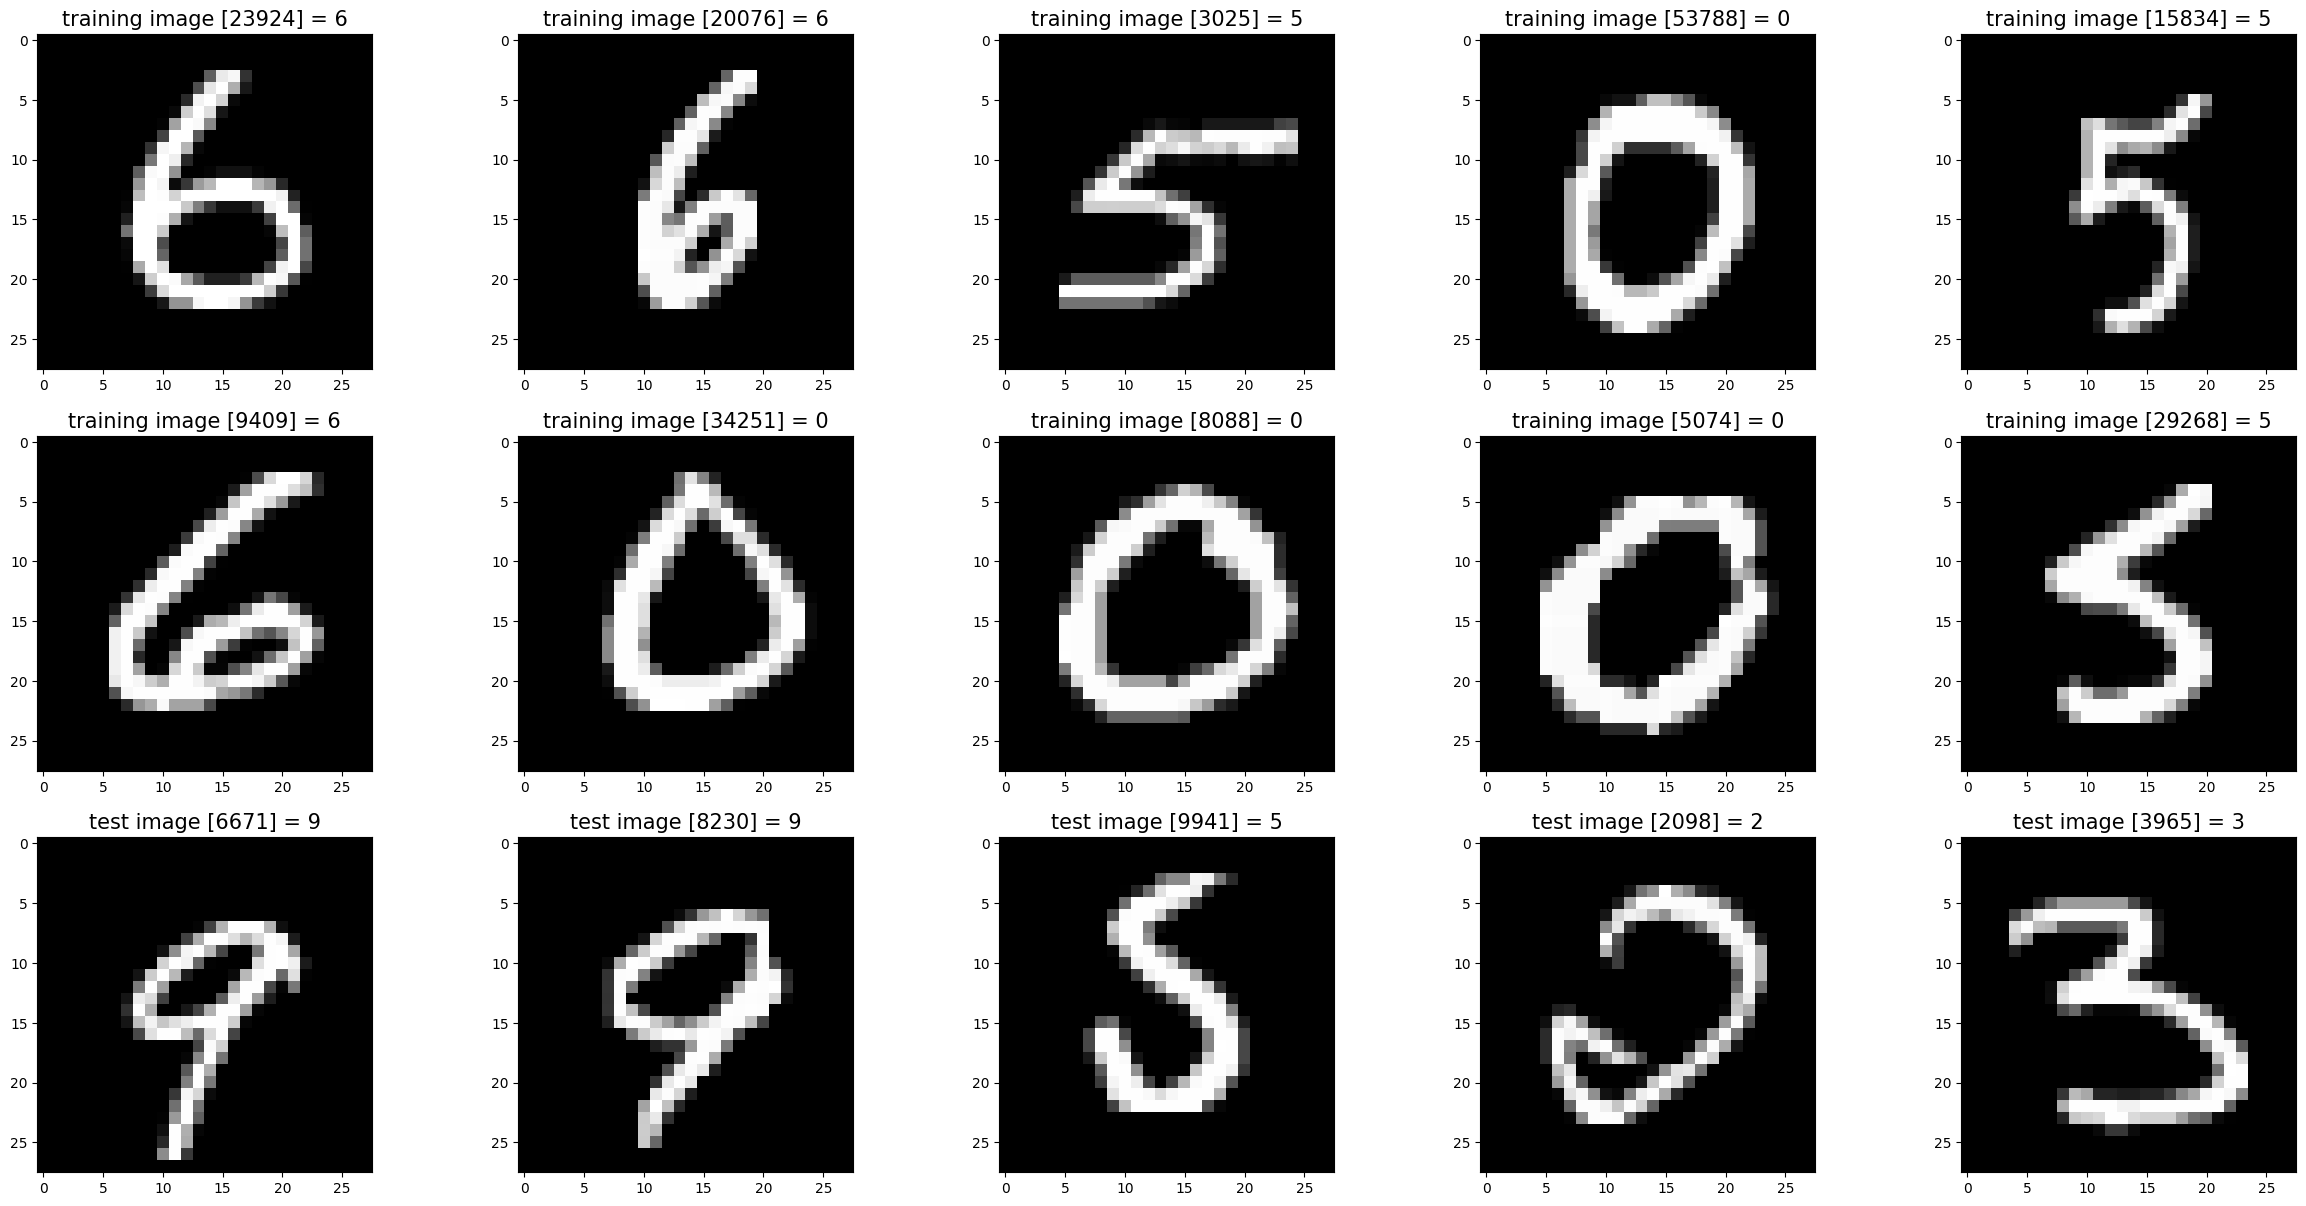

In [122]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

input_path = path
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1


mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [123]:
import numpy as np

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

print("Training data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)


Training data shape: (60000, 28, 28) (60000,)
Test data shape: (10000, 28, 28) (10000,)


<h2>(1): Neural network architecture</h2>
<p>We will build a neural network with three layers, each containing 50 neurons, and a final output layer that uses the Softmax activation function to classify the digits.</p>

In [124]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

def create_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),  
        Dense(50, activation='relu'),   
        Dense(50, activation='relu'),   
        Dense(50, activation='relu'),   
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

<h2>(2): Splitting the MNIST dataset</h2>
<p>We will plit the data in 10 datasets where each dataset consists only one class labels (numbers from 0 to 9).
</p>

In [125]:
train_class_datasets = {i: ([], []) for i in range(10)}
test_class_datasets = {i: ([], []) for i in range(10)}

for i in range(10):
    train_class_indices = (y_train == i)
    train_class_datasets[i] = (x_train[train_class_indices], y_train[train_class_indices])

for i in range(10):
    test_class_indices = (y_test == i)
    test_class_datasets[i] = (x_test[test_class_indices], y_test[test_class_indices])

print("Training data counts per class:")
for i in range(10):
    print(f"Class {i}: {len(train_class_datasets[i][0])} images")

print("\nTesting data counts per class:")
for i in range(10):
    print(f"Class {i}: {len(test_class_datasets[i][0])} images")


Training data counts per class:
Class 0: 5923 images
Class 1: 6742 images
Class 2: 5958 images
Class 3: 6131 images
Class 4: 5842 images
Class 5: 5421 images
Class 6: 5918 images
Class 7: 6265 images
Class 8: 5851 images
Class 9: 5949 images

Testing data counts per class:
Class 0: 980 images
Class 1: 1135 images
Class 2: 1032 images
Class 3: 1010 images
Class 4: 982 images
Class 5: 892 images
Class 6: 958 images
Class 7: 1028 images
Class 8: 974 images
Class 9: 1009 images


<h2>Verifying the corectness of splitting the dataset </h2>
<p>Making sure that the dataset is split accordingly.</p>

Displaying random training images from each class:

Displaying random test images from each class:


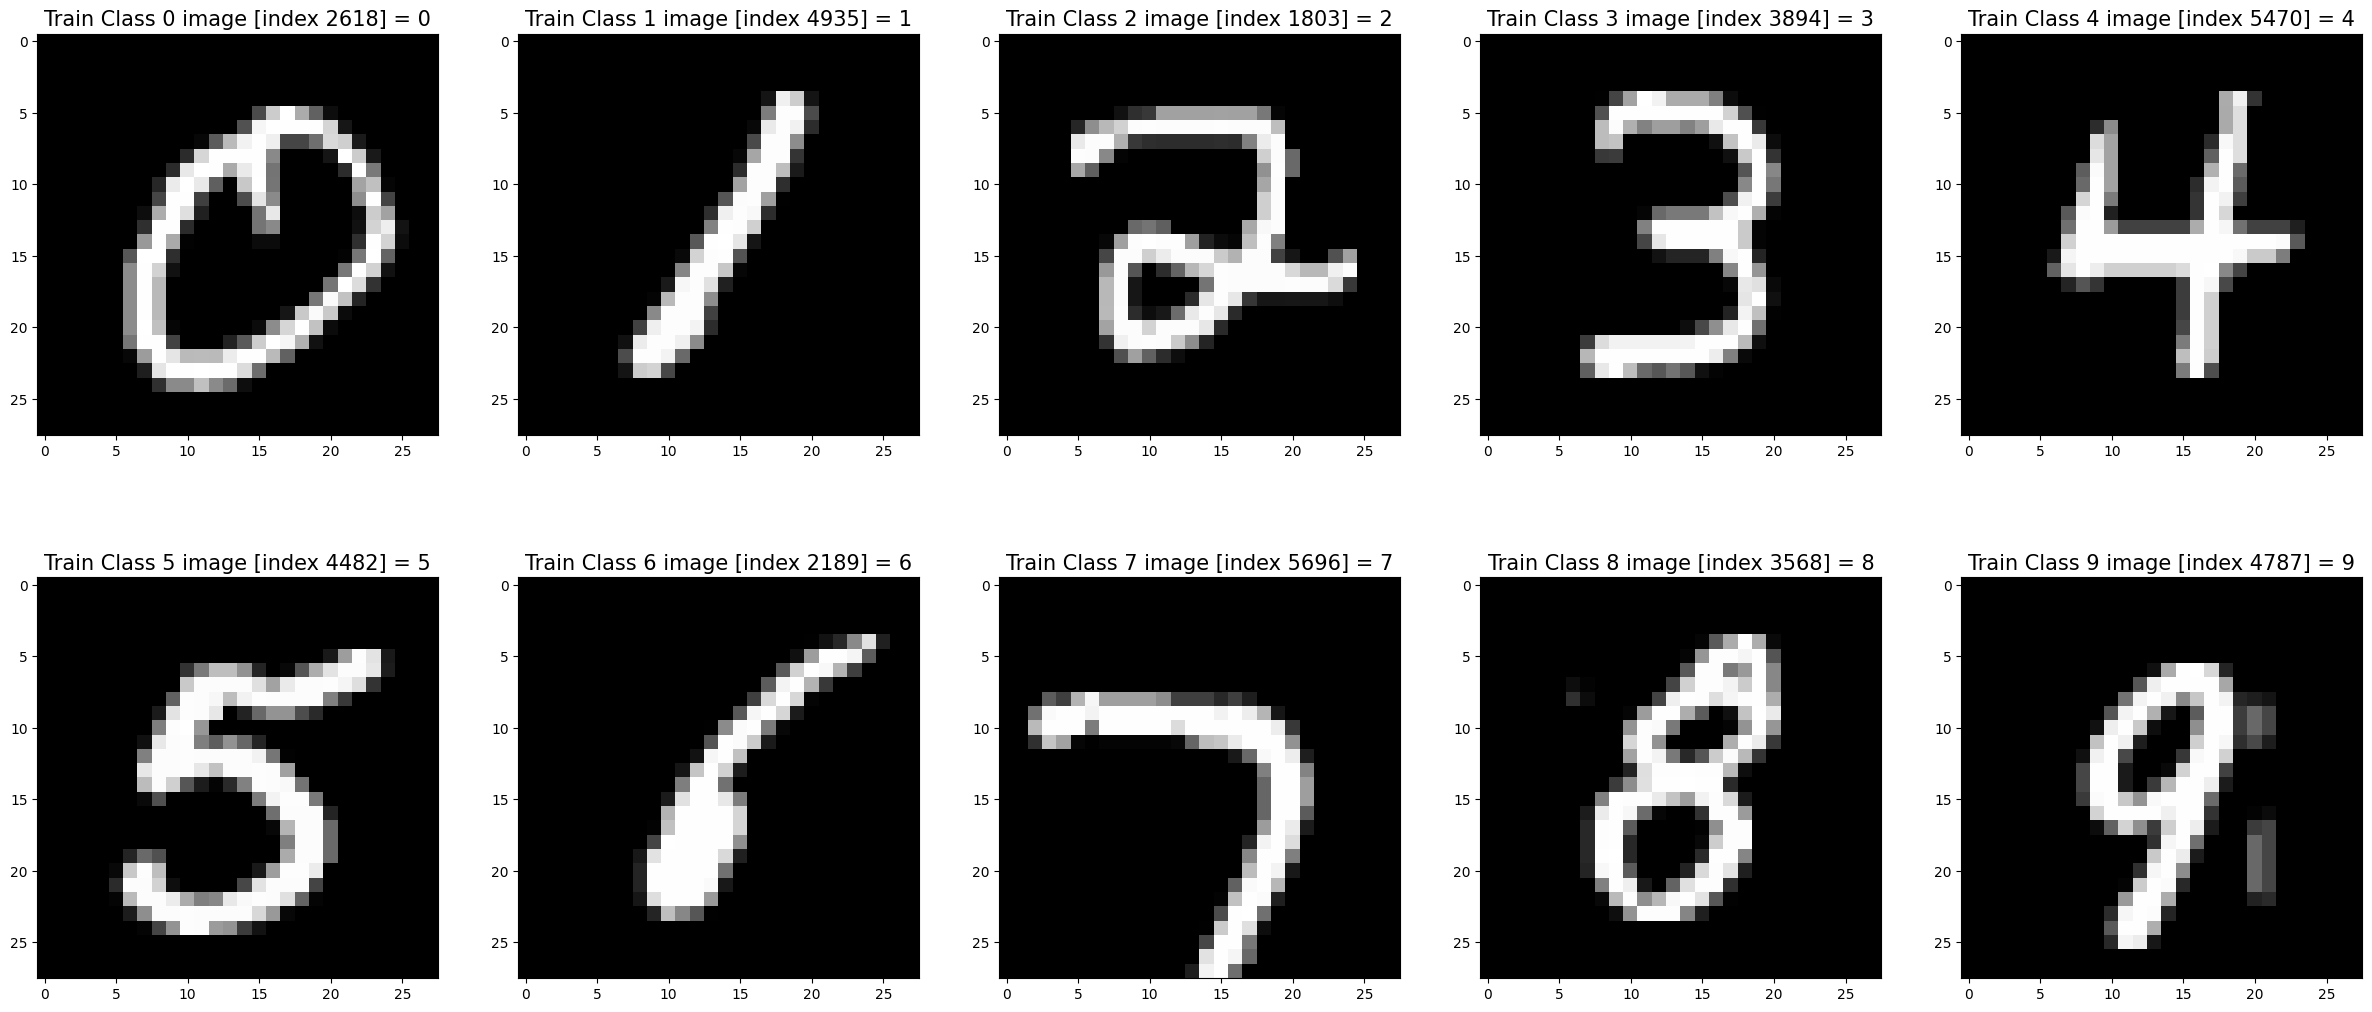

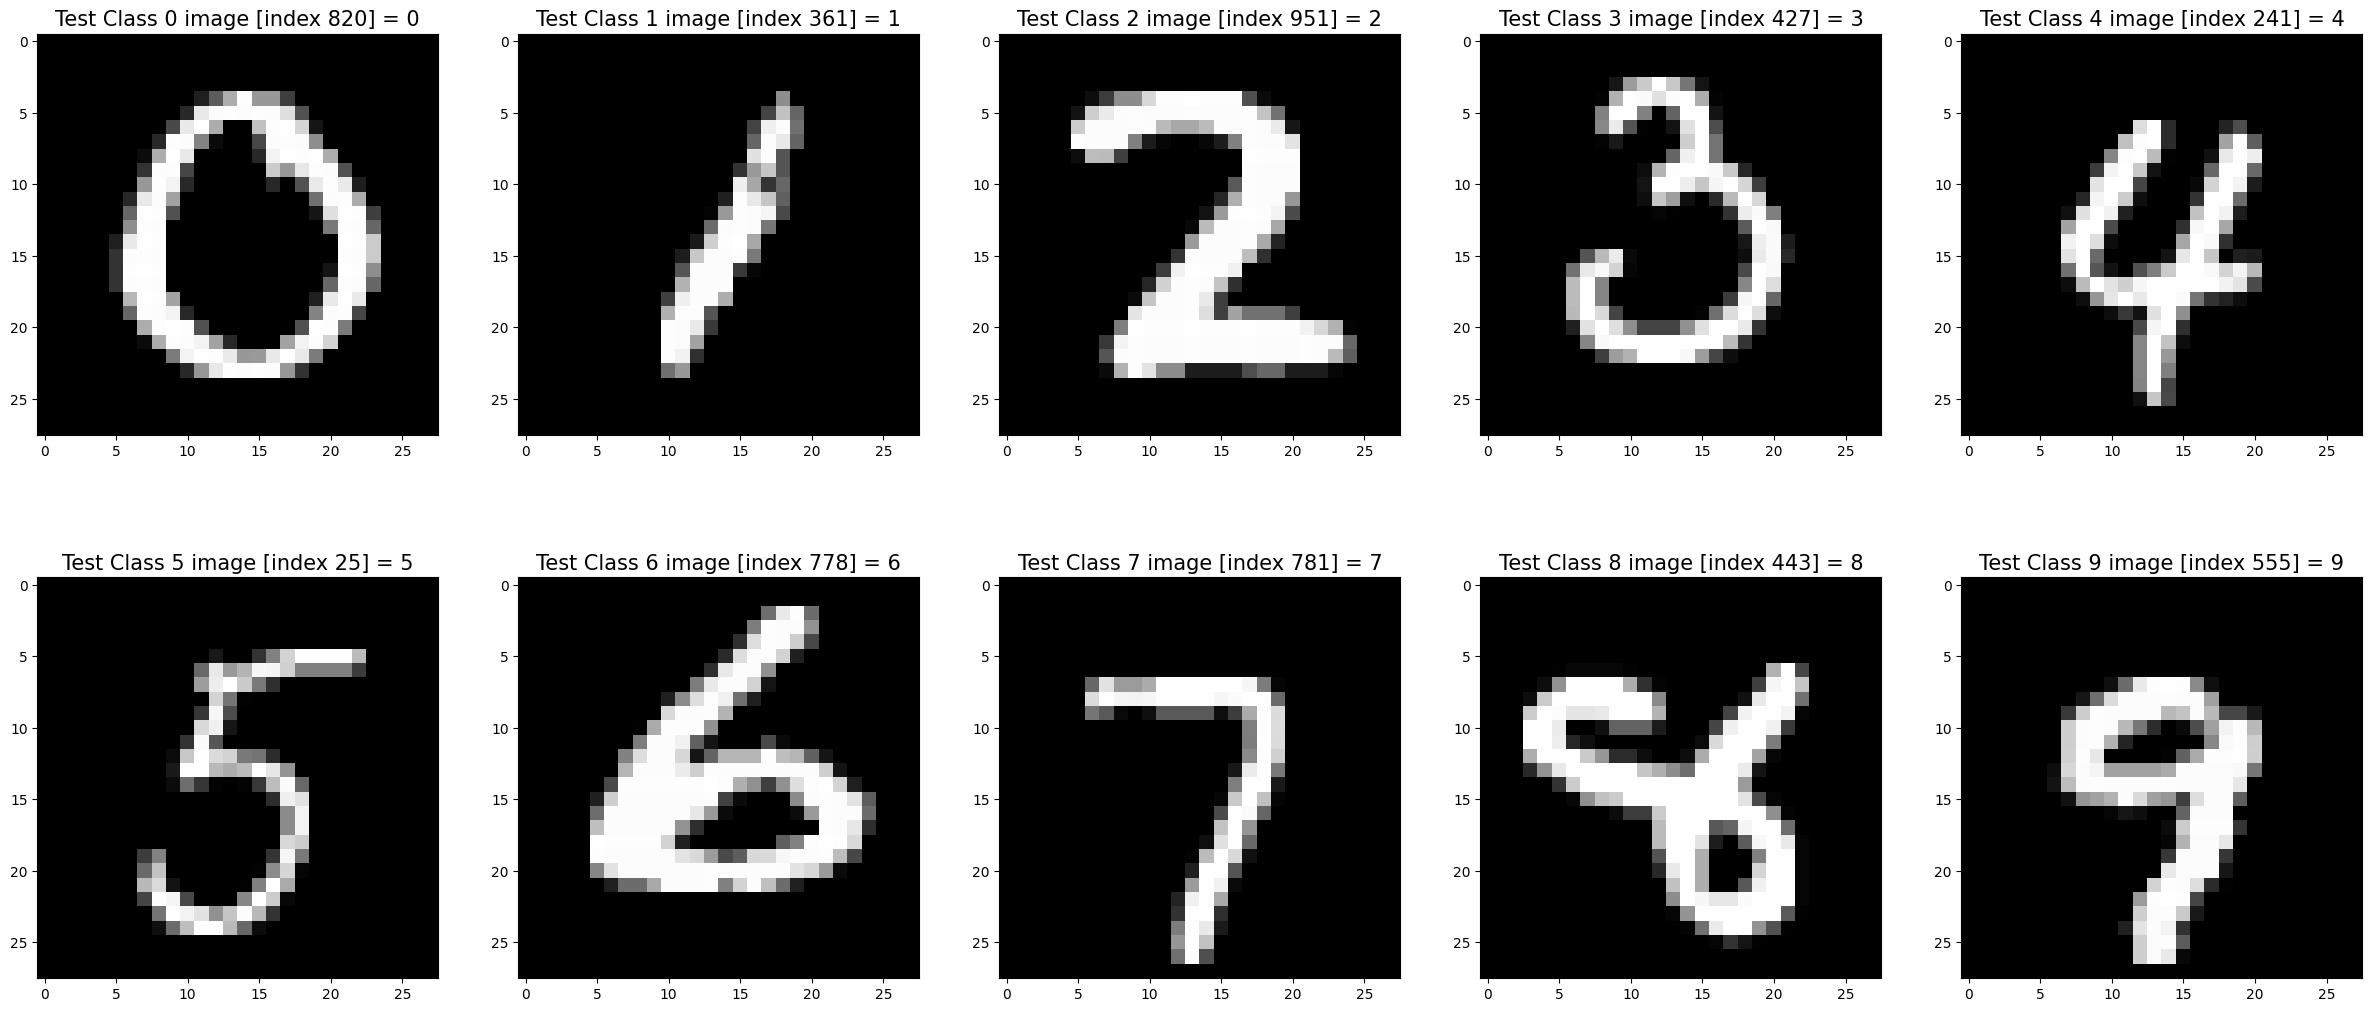

In [126]:
import random

split_images_2_show = []
split_titles_2_show = []

print("Displaying random training images from each class:")

for i in range(10):
    r = random.randint(0, len(train_class_datasets[i][0]) - 1)
    
    split_images_2_show.append(train_class_datasets[i][0][r])
    split_titles_2_show.append(f'Train Class {i} image [index {r}] = {train_class_datasets[i][1][r]}')

show_images(split_images_2_show, split_titles_2_show)

split_images_2_show.clear()
split_titles_2_show.clear()

print("\nDisplaying random test images from each class:")

for i in range(10):
    r = random.randint(0, len(test_class_datasets[i][0]) - 1)
    
    split_images_2_show.append(test_class_datasets[i][0][r])
    split_titles_2_show.append(f'Test Class {i} image [index {r}] = {test_class_datasets[i][1][r]}')

show_images(split_images_2_show, split_titles_2_show)

<h2>Creating 3 groups of sub-datasets for each dataset from the previous step</h2>
<p>Augmenting each dataset with 5%, 10% and 15% rows compared to initial size, where additional percentage of rows are randomly selected from other 9 classes of datasets from the previous step. </p>

In [127]:
import numpy as np

def augment_dataset_with_all_classes(class_datasets, percentage):
    augmented_datasets = {}
    for i in range(10):
        x_current, y_current = class_datasets[i]
        
        num_to_add = int(len(x_current) * percentage / 100)
        
        other_classes_indices = [j for j in range(10) if j != i]
        min_samples_per_class = num_to_add // len(other_classes_indices)
        
        augmented_x, augmented_y = x_current.copy(), y_current.copy()
        
        samples_added = 0
        for other_class in other_classes_indices:
            x_other, y_other = class_datasets[other_class]
            
            selected_indices = np.random.choice(len(x_other), min_samples_per_class, replace=False)
            augmented_x = np.append(augmented_x, x_other[selected_indices], axis=0)
            augmented_y = np.append(augmented_y, y_other[selected_indices], axis=0)
            samples_added += min_samples_per_class

        while samples_added < num_to_add:
            random_class = np.random.choice(other_classes_indices)
            x_other, y_other = class_datasets[random_class]
            
            random_index = np.random.randint(0, len(x_other))
            augmented_x = np.append(augmented_x, [x_other[random_index]], axis=0)
            augmented_y = np.append(augmented_y, [y_other[random_index]], axis=0)
            samples_added += 1
        
        augmented_datasets[i] = (augmented_x, augmented_y)
    
    return augmented_datasets

def create_augmented_groups(train_class_datasets, test_class_datasets):
    augmented_train_datasets = {
        'group_a': augment_dataset_with_all_classes(train_class_datasets, 5),  
        'group_b': augment_dataset_with_all_classes(train_class_datasets, 10), 
        'group_c': augment_dataset_with_all_classes(train_class_datasets, 15), 
    }

    augmented_test_datasets = {
        'group_a': augment_dataset_with_all_classes(test_class_datasets, 5),  
        'group_b': augment_dataset_with_all_classes(test_class_datasets, 10),
        'group_c': augment_dataset_with_all_classes(test_class_datasets, 15), 
    }

    return augmented_train_datasets, augmented_test_datasets

augmented_train_datasets, augmented_test_datasets = create_augmented_groups(train_class_datasets, test_class_datasets)

<h3>Verifying the augmented datasets</h3>

In [128]:
x_train_group_a_0, y_train_group_a_0 = augmented_train_datasets['group_a'][0]

In [129]:
x_train_group_a_0.shape

(6219, 28, 28)

Displaying random training images from each class:


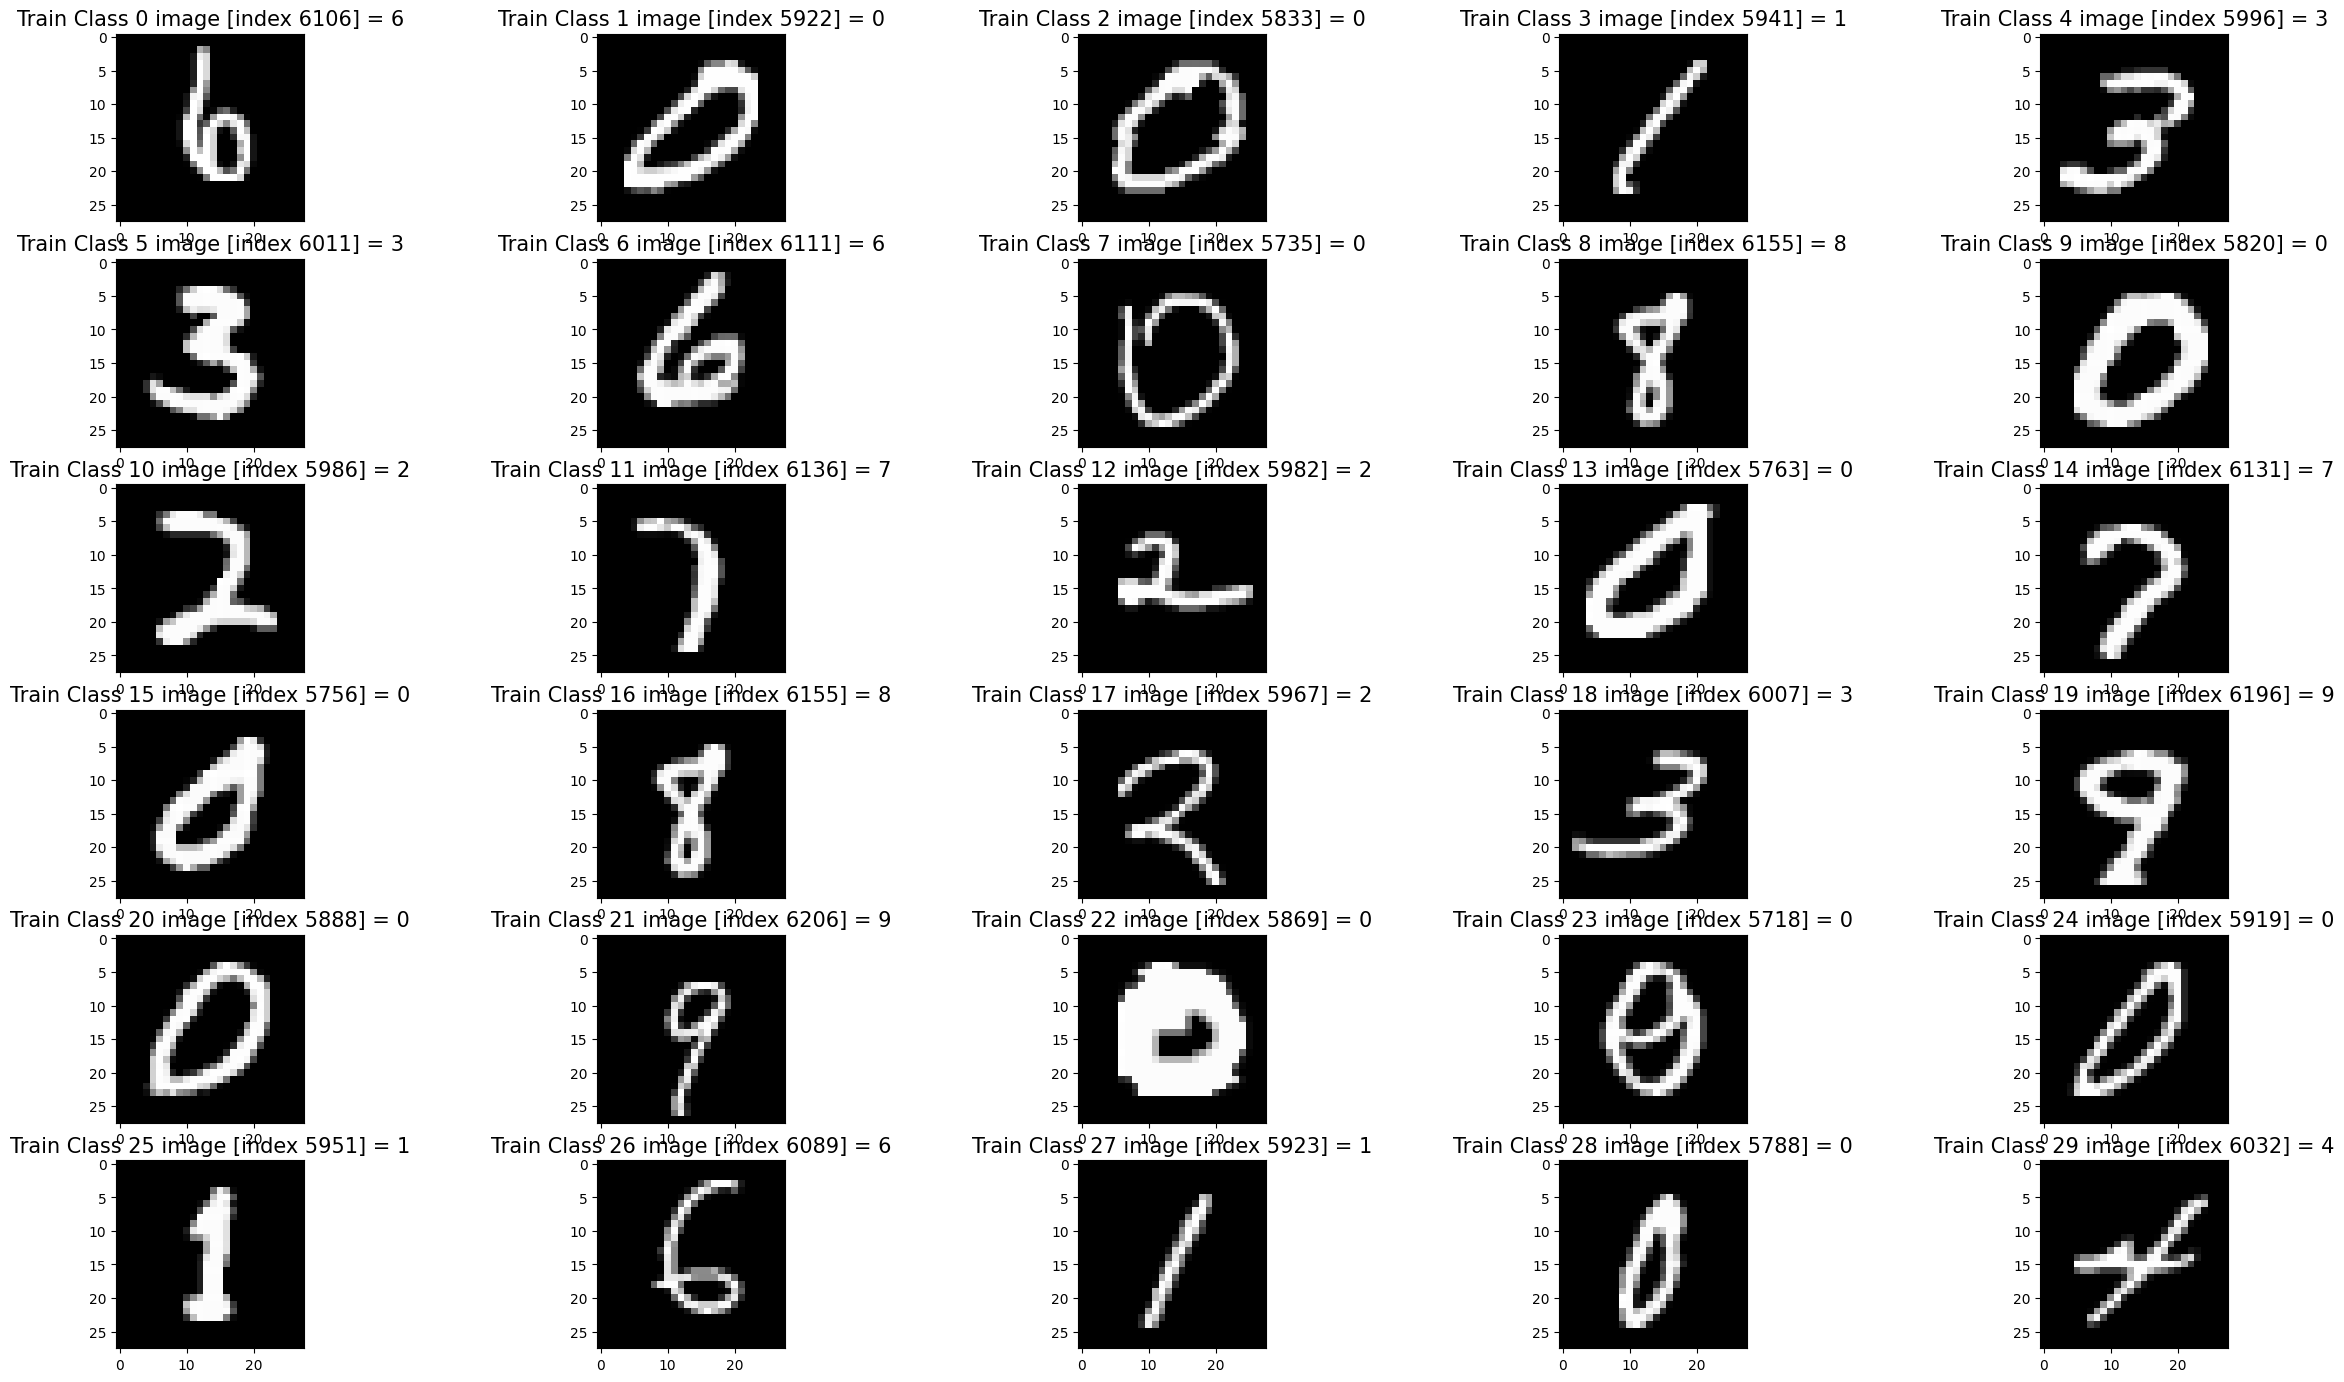

In [135]:
import random

augmented_images_2_show = []
augmented_titles_2_show = []

print("Displaying random training images from each class:")

for i in range(30):
    r = random.randint(5700, len(x_train_group_a_0) - 1)
    
    augmented_images_2_show.append(x_train_group_a_0[r])
    augmented_titles_2_show.append(f'Train Class {i} image [index {r}] = {y_train_group_a_0[r]}')

show_images(augmented_images_2_show, augmented_titles_2_show)

<h2>Training models on each of 30 sub-datasets</h2>
<p>Early stopping is used to determine the number of iterations(and epochs) for each neural network configuration training with each dataset.</p>

In [146]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
import time


early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5,         
                               restore_best_weights=True)

class IterationLogger(Callback):
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name
        self.iteration_data = []
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_end_iteration = self.model.optimizer.iterations.numpy()
        total_iterations = epoch_end_iteration
        if epoch > 0:
            total_iterations -= self.epoch_start_iteration
        
        self.iteration_data.append(total_iterations)
        self.epoch_start_iteration = epoch_end_iteration
        
    def on_train_end(self, logs=None):
        self.training_time = time.time() - self.start_time

        model_performance[self.model_name] = {
            'iterations': sum(self.iteration_data),
            'epochs': len(self.iteration_data),
            'training_time': self.training_time
        }

model_performance = {}
models = {}
history_objects = {}

groups = ['group_a', 'group_b', 'group_c']


for group in groups:
    for i in range(10):  
        print(f"Training on class {i} in {group} dataset")

        x_train, y_train = augmented_train_datasets[group][i]
        x_test, y_test = augmented_test_datasets[group][i]

        x_train, x_test = x_train / 255.0, x_test / 255.0

        shuffle_indices = np.random.permutation(len(x_train))
        x_train = x_train[shuffle_indices]
        y_train = y_train[shuffle_indices]

        model = create_model()

        iteration_logger = IterationLogger(model_name=f"{group}_class_{i}")

        history = model.fit(x_train, y_train,
                            epochs=100,
                            validation_split=0.2,
                            callbacks=[early_stopping, iteration_logger])

        history_objects[f"{group}_class_{i}"] = history.history

        models[f"{group}_class_{i}"] = model

        test_loss, test_acc = model.evaluate(x_test, y_test)
        print(f"Test accuracy for {group}_class_{i}: {test_acc:.4f}")

Training on class 0 in group_a dataset
Epoch 1/100
156/156 [==============================] - 1s 7ms/step - loss: 0.3233 - accuracy: 0.9335 - val_loss: 0.1382 - val_accuracy: 0.9590
Epoch 2/100
156/156 [==============================] - 1s 7ms/step - loss: 0.1248 - accuracy: 0.9616 - val_loss: 0.1010 - val_accuracy: 0.9759
Epoch 3/100
156/156 [==============================] - 1s 4ms/step - loss: 0.0767 - accuracy: 0.9783 - val_loss: 0.0659 - val_accuracy: 0.9815
Epoch 4/100
156/156 [==============================] - 1s 4ms/step - loss: 0.0451 - accuracy: 0.9873 - val_loss: 0.0571 - val_accuracy: 0.9839
Epoch 5/100
156/156 [==============================] - 1s 5ms/step - loss: 0.0240 - accuracy: 0.9944 - val_loss: 0.0532 - val_accuracy: 0.9920
Epoch 6/100
156/156 [==============================] - 1s 6ms/step - loss: 0.0156 - accuracy: 0.9970 - val_loss: 0.0640 - val_accuracy: 0.9799
Epoch 7/100
156/156 [==============================] - 1s 6ms/step - loss: 0.0129 - accuracy: 0.9970 - 

In [155]:
import pandas as pd

df_performance = pd.DataFrame(model_performance).T

df_performance.to_csv("model_performance.csv", index=True)

print(df_performance)

                 iterations  epochs  training_time
group_a_class_0      1872.0    12.0      11.031202
group_a_class_1      1947.0    11.0      11.732309
group_a_class_2      1727.0    11.0      10.405755
group_a_class_3      1771.0    11.0      10.897519
group_a_class_4      1848.0    12.0      11.147976
group_a_class_5      2002.0    14.0      12.453529
group_a_class_6      2028.0    13.0      12.452987
group_a_class_7      1485.0     9.0       9.357892
group_a_class_8      1540.0    10.0       9.773028
group_a_class_9      2198.0    14.0      13.214804
group_b_class_0      1956.0    12.0      11.094438
group_b_class_1      2232.0    12.0      12.706231
group_b_class_2      2132.0    13.0      11.887393
group_b_class_3      1859.0    11.0      10.635694
group_b_class_4      1932.0    12.0      12.130614
group_b_class_5      1650.0    11.0      10.288982
group_b_class_6      1630.0    10.0       9.652329
group_b_class_7      2422.0    14.0      14.835574
group_b_class_8      2254.0    

In [148]:
history_objects["group_a_class_0"]

{'loss': [0.32325279712677,
  0.12483590096235275,
  0.07668651640415192,
  0.045052669942379,
  0.023997148498892784,
  0.015578409656882286,
  0.012915772385895252,
  0.0063187978230416775,
  0.0040407124906778336,
  0.002648078603670001,
  0.002853765618056059,
  0.0014120686100795865],
 'accuracy': [0.9334673285484314,
  0.9616080522537231,
  0.9782914519309998,
  0.9873366951942444,
  0.9943718314170837,
  0.9969848990440369,
  0.9969848990440369,
  0.9989949464797974,
  0.9997990131378174,
  0.99959796667099,
  0.9993969798088074,
  1.0],
 'val_loss': [0.13816404342651367,
  0.10095960646867752,
  0.06587027758359909,
  0.05714680999517441,
  0.05317923054099083,
  0.06400096416473389,
  0.05231372267007828,
  0.05904104560613632,
  0.052414994686841965,
  0.06118762120604515,
  0.06362573057413101,
  0.0672859400510788],
 'val_accuracy': [0.959003210067749,
  0.9758842587471008,
  0.9815112352371216,
  0.9839228391647339,
  0.9919614195823669,
  0.979903519153595,
  0.9879420995

<h2>Developing ensemble models</h2>
<p>In this step, three ensemble models are developed and they are based on the models trained in the previous step. There are three variations of developed ensemble models.</p>
<p>First variation of ensemble model uses voting method where the final prediction is the output of the submodel which has the most confidence in its prediction. Max voting.</p>
<p>Second variation of ensemble models are based on averaging the prediction confidences from all of the submodels in the ensemble. We take an average confidence for each class from all submodels and as a final output we take the maximum average confidence.</p>
<p>Third variation of ensemble model is based on using the knowledge of each submodel's "specialty class", for example: submodel called "group_a_class_0" is primarily trained on a class 0 with a small percentage of other classes. So, using this knowledge, about this submodel, we weigh its confidence about its prediction more than other model's prediction confidences.</p>

<p>The standard voting method was not used because of the nature of the problem. Each submodel is specialized for classifing only one class with solid accuracy, so the standard voting method would result with 1 good submodel's prediction versus 9 other submodel's predictions, where other 9 submodels are not properly trained for that class, which would most likely result in bad final prediction. </p>

In [149]:
models_group_a = [
    models['group_a_class_0'], models['group_a_class_1'], models['group_a_class_2'],
    models['group_a_class_3'], models['group_a_class_4'], models['group_a_class_5'],
    models['group_a_class_6'], models['group_a_class_7'], models['group_a_class_8'],
    models['group_a_class_9']
]

models_group_b = [
    models['group_b_class_0'], models['group_b_class_1'], models['group_b_class_2'],
    models['group_b_class_3'], models['group_b_class_4'], models['group_b_class_5'],
    models['group_b_class_6'], models['group_b_class_7'], models['group_b_class_8'],
    models['group_b_class_9']
]

models_group_c = [
    models['group_c_class_0'], models['group_c_class_1'], models['group_c_class_2'],
    models['group_c_class_3'], models['group_c_class_4'], models['group_c_class_5'],
    models['group_c_class_6'], models['group_c_class_7'], models['group_c_class_8'],
    models['group_c_class_9']
]

In [150]:
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

import numpy as np

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

print("Training data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)

Training data shape: (60000, 28, 28) (60000,)
Test data shape: (10000, 28, 28) (10000,)


In [161]:
import numpy as np

def ensemble_predict(models_group, x_test):
    final_predictions = []

    all_confidences = [] 
    all_predictions = []

    for model in models_group:
        probs = model.predict(x_test, verbose=0)
        
        predicted_classes = np.argmax(probs, axis=1) 
        confidences = np.max(probs, axis=1) 
        
        all_confidences.append(confidences) 
        all_predictions.append(predicted_classes)

    all_confidences = np.array(all_confidences)
    all_predictions = np.array(all_predictions)

    max_confidence_indices = np.argmax(all_confidences, axis=0)

    for i in range(x_test.shape[0]): 
        model_idx = max_confidence_indices[i]
        
        final_prediction = all_predictions[model_idx, i]
        
        final_predictions.append(final_prediction)

    return np.array(final_predictions)

x_test_normalized = x_test / 255.0  

predictions_group_a_max_voting = ensemble_predict(models_group_a, x_test_normalized)
predictions_group_b_max_voting = ensemble_predict(models_group_b, x_test_normalized)
predictions_group_c_max_voting = ensemble_predict(models_group_c, x_test_normalized)

accuracy_group_a_max_voting = np.mean(predictions_group_a_max_voting == y_test)
accuracy_group_b_max_voting = np.mean(predictions_group_b_max_voting == y_test)
accuracy_group_c_max_voting = np.mean(predictions_group_c_max_voting == y_test)

print(f"Ensemble accuracy for Group A models: {accuracy_group_a_max_voting * 100:.2f}%")
print(f"Ensemble accuracy for Group B models: {accuracy_group_b_max_voting * 100:.2f}%")
print(f"Ensemble accuracy for Group C models: {accuracy_group_c_max_voting * 100:.2f}%")


Ensemble accuracy for Group A models: 91.92%
Ensemble accuracy for Group B models: 93.67%
Ensemble accuracy for Group C models: 93.87%


In [162]:
import numpy as np
from sklearn.metrics import accuracy_score

def ensemble_predict_avg(models_group, x_test):
    final_predictions = []

    all_probs = []

    for model in models_group:
        probs = model.predict(x_test, verbose=0)  
        all_probs.append(probs) 

    all_probs = np.array(all_probs)

    avg_confidences = np.mean(all_probs, axis=0) 

    final_predictions = np.argmax(avg_confidences, axis=1)

    return final_predictions

x_test_normalized = x_test / 255.0 

predictions_group_a_avg = ensemble_predict_avg(models_group_a, x_test_normalized)
predictions_group_b_avg = ensemble_predict_avg(models_group_b, x_test_normalized)
predictions_group_c_avg = ensemble_predict_avg(models_group_c, x_test_normalized)

accuracy_group_a_avg = np.mean(predictions_group_a_avg == y_test)
accuracy_group_b_avg = np.mean(predictions_group_b_avg == y_test)
accuracy_group_c_avg = np.mean(predictions_group_c_avg == y_test)

print(f"Ensemble accuracy (averaging) for Group A models: {accuracy_group_a_avg * 100:.2f}%")
print(f"Ensemble accuracy (averaging) for Group B models: {accuracy_group_b_avg * 100:.2f}%")
print(f"Ensemble accuracy (averaging) for Group C models: {accuracy_group_c_avg * 100:.2f}%")


Ensemble accuracy (averaging) for Group A models: 89.37%
Ensemble accuracy (averaging) for Group B models: 91.64%
Ensemble accuracy (averaging) for Group C models: 92.02%


In [163]:
import numpy as np

def ensemble_predict_weighted(models_group, x_test, specialties):
    final_predictions = []
    all_confidences = []
    all_predictions = []

    for i, model in enumerate(models_group):
        probs = model.predict(x_test, verbose=0)
        predicted_classes = np.argmax(probs, axis=1)
        confidences = np.max(probs, axis=1)

        specialty_class = specialties[i]
        weighted_confidences = [
            confidence if predicted_class == specialty_class else confidence * 0.7
            for predicted_class, confidence in zip(predicted_classes, confidences)
        ]

        all_confidences.append(weighted_confidences)
        all_predictions.append(predicted_classes)

    all_confidences = np.array(all_confidences)
    all_predictions = np.array(all_predictions)

    max_confidence_indices = np.argmax(all_confidences, axis=0)

    for i in range(x_test.shape[0]):
        final_prediction = all_predictions[max_confidence_indices[i], i]
        final_predictions.append(final_prediction)

    return np.array(final_predictions)

x_test_normalized = x_test / 255.0
specialties = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 

predictions_group_a_weighted = ensemble_predict_weighted(models_group_a, x_test_normalized, specialties)
predictions_group_b_weighted = ensemble_predict_weighted(models_group_b, x_test_normalized, specialties)
predictions_group_c_weighted = ensemble_predict_weighted(models_group_c, x_test_normalized, specialties)

accuracy_group_a_weighted = np.mean(predictions_group_a_weighted == y_test)
accuracy_group_b_weighted = np.mean(predictions_group_b_weighted == y_test)
accuracy_group_c_weighted = np.mean(predictions_group_c_weighted == y_test)

print(f"Ensemble accuracy for Group A models: {accuracy_group_a_weighted * 100:.2f}%")
print(f"Ensemble accuracy for Group B models: {accuracy_group_b_weighted * 100:.2f}%")
print(f"Ensemble accuracy for Group C models: {accuracy_group_c_weighted * 100:.2f}%")


Ensemble accuracy for Group A models: 91.93%
Ensemble accuracy for Group B models: 93.59%
Ensemble accuracy for Group C models: 94.02%


<h2>Total learning time for each of ensemble models (training of 10 sub-models)</h2>
<p>In this step, we calculate the total number of iterations per three models (sum of iterations of sub-models).</p>
<p>During the training of each submodel, we saved all of the data that we need for this step, and that data is used in the next task.</p>

In [164]:
import pandas as pd

df_performance = pd.read_csv("model_performance.csv", index_col=0)

df_performance['group'] = df_performance.index.str.split('_').str[0] + "_" + df_performance.index.str.split('_').str[1]

group_totals = df_performance.groupby('group').agg({
    'training_time': 'sum',
    'iterations': 'sum'
}).rename(columns={'training_time': 'total_training_time', 'iterations': 'total_iterations'})

print("\nTotal training time and iterations for each group:")
print(group_totals)



Total training time and iterations for each group:
         total_training_time  total_iterations
group                                         
group_a           112.467002           18418.0
group_b           119.373199           20035.0
group_c           119.006512           19181.0


<h2>Testing the variants of three ensemble models with test data</h2>

<p>Group A is a group of sub-datasets where each dataset is augmented with additional 5% rows randomly selected from other 9 classes. Group B and C are groups augmented with additional 10% and 15% rows, respectively. </p>

In [165]:
print("Max vote variant")
print(f"Ensemble accuracy for Group A models: {accuracy_group_a_max_voting * 100:.2f}%")
print(f"Ensemble accuracy for Group B models: {accuracy_group_b_max_voting * 100:.2f}%")
print(f"Ensemble accuracy for Group C models: {accuracy_group_c_max_voting * 100:.2f}%")

print("\nAveraging confidences variant")
print(f"Ensemble accuracy (averaging) for Group A models: {accuracy_group_a_avg * 100:.2f}%")
print(f"Ensemble accuracy (averaging) for Group B models: {accuracy_group_b_avg * 100:.2f}%")
print(f"Ensemble accuracy (averaging) for Group C models: {accuracy_group_c_avg * 100:.2f}%")

print("\nWeighted confidences variant")
print(f"Ensemble accuracy for Group A models: {accuracy_group_a_weighted * 100:.2f}%")
print(f"Ensemble accuracy for Group B models: {accuracy_group_b_weighted * 100:.2f}%")
print(f"Ensemble accuracy for Group C models: {accuracy_group_c_weighted * 100:.2f}%")

Max vote variant
Ensemble accuracy for Group A models: 91.92%
Ensemble accuracy for Group B models: 93.67%
Ensemble accuracy for Group C models: 93.87%

Averaging confidences variant
Ensemble accuracy (averaging) for Group A models: 89.37%
Ensemble accuracy (averaging) for Group B models: 91.64%
Ensemble accuracy (averaging) for Group C models: 92.02%

Weighted confidences variant
Ensemble accuracy for Group A models: 91.93%
Ensemble accuracy for Group B models: 93.59%
Ensemble accuracy for Group C models: 94.02%


<h1>Plotting the dependencies</h1>

<p>In this step, we will plot the dependence of accuracy (x-axis) and training time (y-axis) on one scatter plot, and dependence of accuracy (x-axis) and number of iterations (y-axis) on second scatter plot.</p>

<p>We will do this for each variant of ensemble models.</p>

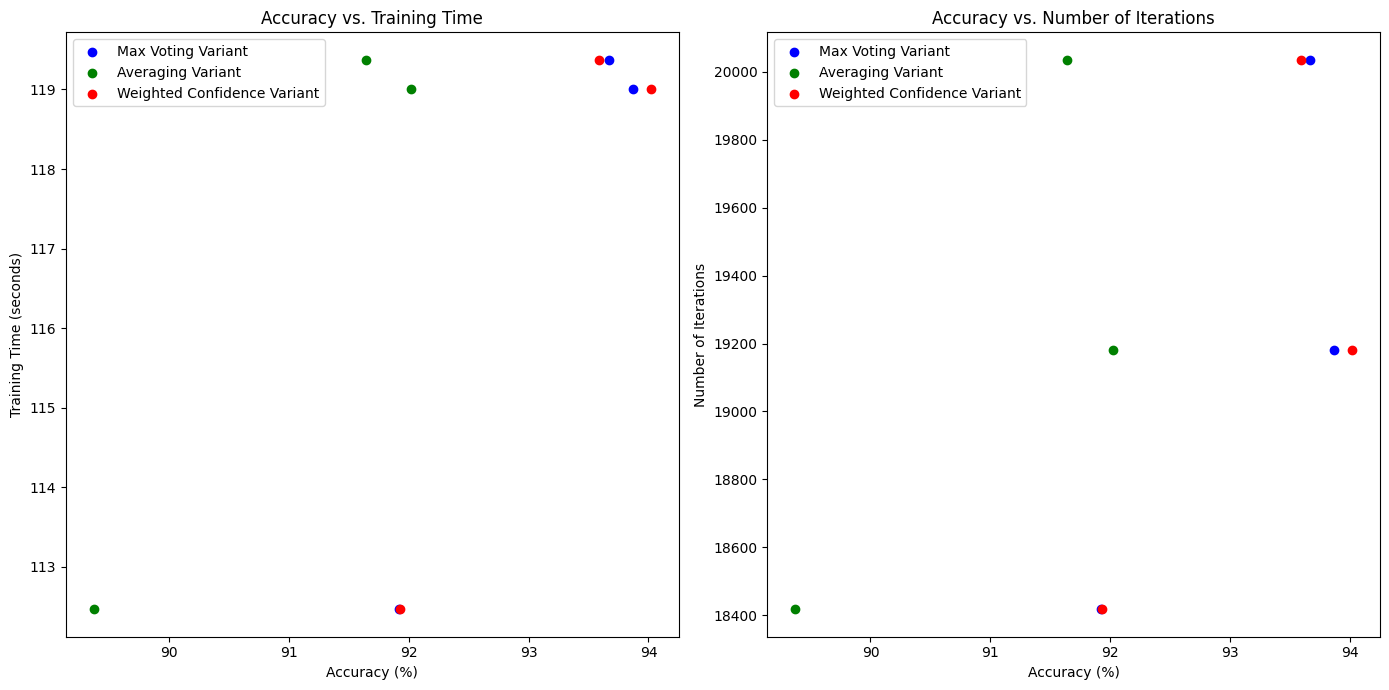

In [166]:
import matplotlib.pyplot as plt

groups = ['Group A', 'Group B', 'Group C']

# Accuracy values for each variant
accuracy_max_vote = [91.92, 93.67, 93.87]
accuracy_averaging = [89.37, 91.64, 92.02]
accuracy_weighted = [91.93, 93.59, 94.02]

# Training time and iterations data
training_time = [112.467002, 119.373199, 119.006512]  # Total training time for group A, B, C
iterations = [18418.0, 20035.0, 19181.0]  # Total iterations for group A, B, C

plt.figure(figsize=(14, 7))

# 1. Accuracy vs. Training Time
plt.subplot(1, 2, 1) 
plt.scatter(accuracy_max_vote, training_time, color='b', label='Max Voting Variant')
plt.scatter(accuracy_averaging, training_time, color='g', label='Averaging Variant')
plt.scatter(accuracy_weighted, training_time, color='r', label='Weighted Confidence Variant')
plt.title('Accuracy vs. Training Time')
plt.xlabel('Accuracy (%)')
plt.ylabel('Training Time (seconds)')
plt.legend()

# 2. Accuracy vs. Number of Iterations
plt.subplot(1, 2, 2) 
plt.scatter(accuracy_max_vote, iterations, color='b', label='Max Voting Variant')
plt.scatter(accuracy_averaging, iterations, color='g', label='Averaging Variant')
plt.scatter(accuracy_weighted, iterations, color='r', label='Weighted Confidence Variant')
plt.title('Accuracy vs. Number of Iterations')
plt.xlabel('Accuracy (%)')
plt.ylabel('Number of Iterations')
plt.legend()

plt.tight_layout()
plt.show()
